# Hodgkin - Huxley model

In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

The Hodgkin Huxley model has 4 differential equations that are coupled with each other:

Equation for the voltage dynamics:

$$C \frac{dV}{dt} = - g_\mathsf{K}(t)(V-E_\mathsf{K}) - g_\mathsf{Na}(t)(V-E_\mathsf{Na}) - g_\mathsf{Cl}(V-E_\mathsf{Cl}) + I_\mathsf{ext}$$


Dynamics of the Na and K conductances: 
$$ g_\mathsf{K}(t) = \bar{g}_\mathsf{K} n^4(t) $$
$$ g_\mathsf{Na}(t) = \bar{g}_\mathsf{Na} m^3(t) h(t) $$


$$ \frac{1}{\alpha_n(V) + \beta_n(V)} \frac{dn}{dt} = -n + \frac{\alpha_n(V)}{\alpha_n(V) + \beta_n(V)} $$

$$ \frac{1}{\alpha_m + \beta_m} \frac{dm}{dt} = -m + \frac{\alpha_m}{\alpha_m + \beta_m} $$

$$ \frac{1}{\alpha_h + \beta_h} \frac{dh}{dt} = -h + \frac{\alpha_h}{\alpha_h + \beta_h} $$

In [2]:
# parameters for a typical cortical neuron

C = 100E-12 # Farads
gCl = 30e-9 # Siemens
ECl = -60   # mV
EK = -82    # mV
ENa = 45    # mV

gK_max = 3.6e-6 # Siemens
gNa_max = 12e-6 # Siemens

alpha_n = lambda v: 0.01*(v+60)/(1-np.exp(-0.1*(v+60)))  # kHz
beta_n = lambda v: 0.12*np.exp(-(v+70)/80)

alpha_m = lambda v: 0.10*(v+45)/(1-np.exp(-0.1*(v+45)))
beta_m = lambda v: 4*np.exp(-(v+70)/18)

alpha_h = lambda v: 0.07*np.exp(-0.05*(v+70))
beta_h = lambda v: 1/(1+np.exp(-0.1*(v+40)))


Let's visualise $\tau_x$ and $x_\infty$ for $x \in \{ 'n', 'm', 'h' \}$: 

Text(0, 0.5, 'gate time constant (ms)')

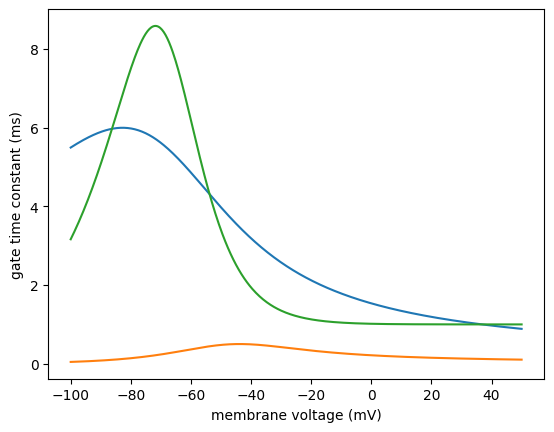

In [3]:
vs = np.linspace(-100, 50, 500)  # linear range of voltage, 500 bins
tau_n = 1/(alpha_n(vs) + beta_n(vs))
tau_m = 1/(alpha_m(vs) + beta_m(vs))
tau_h = 1/(alpha_h(vs) + beta_h(vs))
plt.plot(vs, tau_n)
plt.plot(vs, tau_m)
plt.plot(vs, tau_h)
plt.xlabel("membrane voltage (mV)")
plt.ylabel("gate time constant (ms)")

Text(0, 0.5, 'gate steady state')

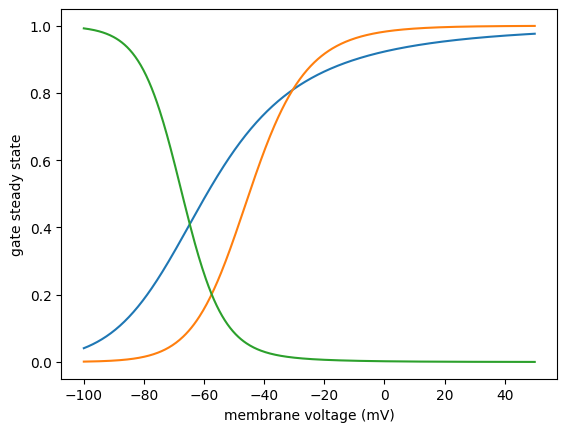

In [4]:
n_inf = alpha_n(vs)/(alpha_n(vs) + beta_n(vs))
m_inf = alpha_m(vs)/(alpha_m(vs) + beta_m(vs))
h_inf = alpha_h(vs)/(alpha_h(vs) + beta_h(vs))
plt.plot(vs, n_inf)
plt.plot(vs, m_inf)
plt.plot(vs, h_inf)
plt.xlabel("membrane voltage (mV)")
plt.ylabel("gate steady state")

In [5]:
# standard Euler integration of the HH equations
# make sure that t is given in ms!
# u is an input current in A
def hh_integrate(ts, u):
    dt = ts[1] - ts[0]  # infer the time step from the time array passed as parameter
    T = np.size(ts) # number of time bins
    
    # initialise the state variables
    v0 = -70.6 # mV  (rough estimate of the resting potential of the cell)
    n0 = alpha_n(v0)/(alpha_n(v0) + beta_n(v0))
    m0 = alpha_m(v0)/(alpha_m(v0) + beta_m(v0))
    h0 = alpha_h(v0)/(alpha_h(v0) + beta_h(v0))
    
    # initialise entire arrays that will store the time evolution of the state vars
    v = v0*np.ones(T)
    n = n0*np.ones(T)
    m = m0*np.ones(T)
    h = h0*np.ones(T)
    
    # loop through time
    for t in range(0, T-1):
        vt = v[t]
        mt = m[t]
        nt = n[t]
        ht = h[t]
        
        ut = u(dt*t) # input current given in Amps
        
        # integrate the voltage equation
        # first, compute the conductances
        gK = gK_max * (nt**4)        # momentary potassium conductance
        gNa = gNa_max * (mt**3) * ht # momentary sodium conductance
        new_vt = vt + dt*1e-3/C*(-gK*(vt-EK) - gNa*(vt-ENa) - gCl*(vt-ECl) + ut*1e3)
        v[t+1] = new_vt
        
        # update the gate variables, taking into account the new voltage
        n[t+1] = nt + dt*(alpha_n(new_vt) - nt*(alpha_n(new_vt)+beta_n(new_vt)))
        m[t+1] = mt + dt*(alpha_m(new_vt) - mt*(alpha_m(new_vt)+beta_m(new_vt)))
        h[t+1] = ht + dt*(alpha_h(new_vt) - ht*(alpha_h(new_vt)+beta_h(new_vt)))
        
    return v, n, m, h
    


In [6]:
ts = np.linspace(0, 100, 4000)  # 4000 time bins between 0 and 100 ms

In [7]:
# input current (Amp)
def u(t):
    if t<45:
        return 0
    elif t<50:
        return 0.5e-9
    else:
        return 0

In [8]:
v, n, m, h = hh_integrate(ts, u)

(-90.0, 45.0)

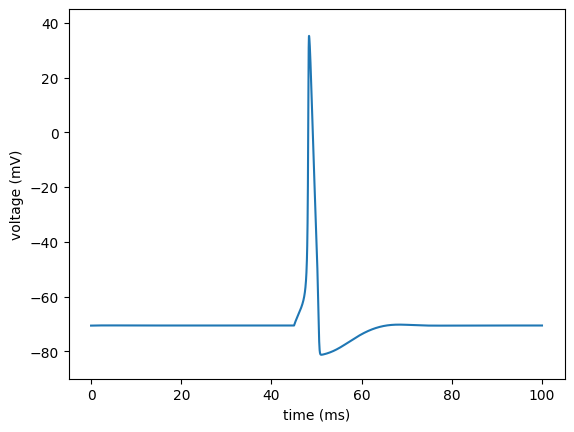

In [9]:
plt.plot(ts, v)
plt.xlabel("time (ms)")
plt.ylabel("voltage (mV)")
plt.ylim(-90,45)

(0.0, 1.0)

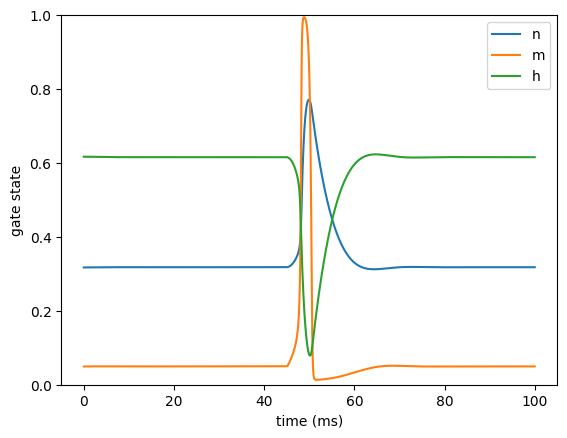

In [10]:
plt.plot(ts, n, label='n')
plt.plot(ts, m, label='m')
plt.plot(ts, h, label='h')
plt.xlabel("time (ms)")
plt.ylabel("gate state")
plt.legend()
plt.ylim(0,1)